In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np

import mne
from mne.preprocessing import (
    ICA,
    compute_proj_ecg,
    compute_proj_eog,
    create_ecg_epochs,
    create_eog_epochs,
)

In [2]:
SUBJECT_ID = "sub-V1008"
SUBJECTS_DIR = "/home/s8/Documents/VU/dataset/subjects_dir/freesurfer"
MEG_DIR = "/home/s8/Documents/VU/dataset/origin"
SAVE_DIR = f"/home/s8/Documents/VU/dataset/workdir/{SUBJECT_ID}"
meg_raw_path = f"{MEG_DIR}/{SUBJECT_ID}/meg/{SUBJECT_ID}_task-visual_meg.ds"

In [3]:
raw = mne.io.read_raw_ctf(meg_raw_path, preload=False)

ds directory : /home/s8/Documents/VU/dataset/origin/sub-V1008/meg/sub-V1008_task-visual_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file not present.
    Quaternion matching (desired vs. transformed):
       0.71   69.51    0.00 mm <->    0.71   69.51    0.00 mm (orig :  -54.48   42.24 -241.72 mm) diff =    0.000 mm
      -0.71  -69.51    0.00 mm <->   -0.71  -69.51   -0.00 mm (orig :   44.30  -55.10 -251.67 mm) diff =    0.000 mm
     104.60    0.00    0.00 mm <->  104.60    0.00   -0.00 mm (orig :   67.65   68.70 -244.83 mm) diff =    0.000 mm
    Coordinate transformations established.
    Polhemus data for 3 HPI coils added
    Device coordinate locations for 3 HPI coils added
Picked positions of 8 EEG channels from channel info
    8 EEG locations added to Polhemus data.
    Measurement info composed.
Finding samples for /home/s8/Documents/VU/dataset/origin/sub-V1008/meg/sub-V1008_task-visual_meg.ds/sub-V1008_task-visual_meg.meg4: 
    System clock 

In [4]:
raw.load_data()

Reading 0 ... 4655943  =      0.000 ...  3879.952 secs...


Measurement date,"January 01, 1970 12:00:00 GMT"
Experimenter,Unknown
Participant,Anonymized6424_1534851944_0
Digitized points,11 points
Good channels,"3 Stimulus, 44 misc, 28 Reference Magnetometers, 273 Magnetometers, 8 EEG"
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,1200.00 Hz
Highpass,0.00 Hz
Lowpass,600.00 Hz


In [5]:
raw.set_channel_types({'EEG057':'eog', 'EEG058': 'eog', 'EEG059': 'ecg'})
# powerline noise
raw = raw.notch_filter([50, 100, 150, 200, 250], filter_length='auto', phase='zero')
# slow drifts
filt_raw = raw.copy().filter(l_freq=1.0, h_freq=None)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 7921 samples (6.601 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    4.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    9.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   16.4s


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 3961 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    4.5s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   10.8s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   29.4s


Using EOG channels: EEG057, EEG058
EOG channel index for this subject is: [305 306]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EEG057 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 12000 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 2 significant peaks
Number of EOG events detected: 2
Not setting metadata
2 matching events found
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 2 events and 1201 original time points ...
    Rejecting  epoch base

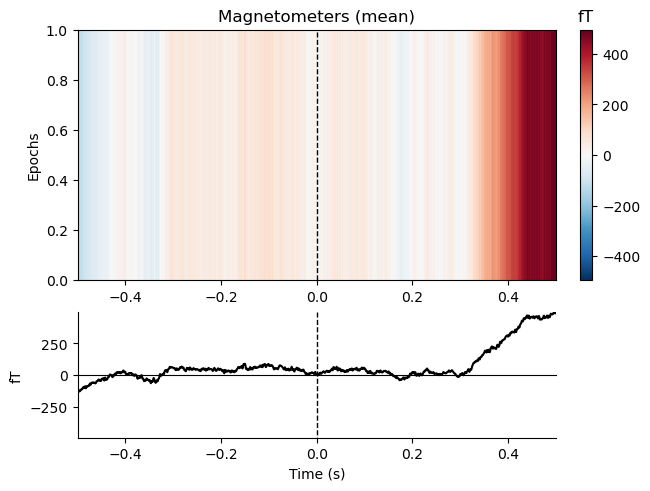

No projector specified for this dataset. Please consider the method self.add_proj.
Removing 5 compensators from info because not all compensation channels were picked.


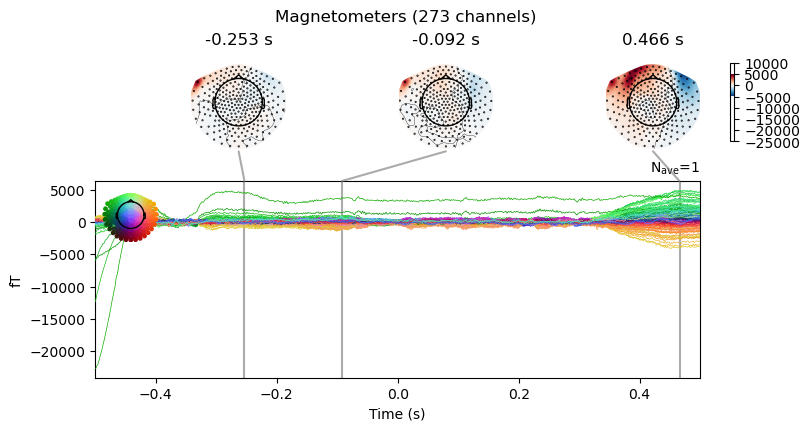

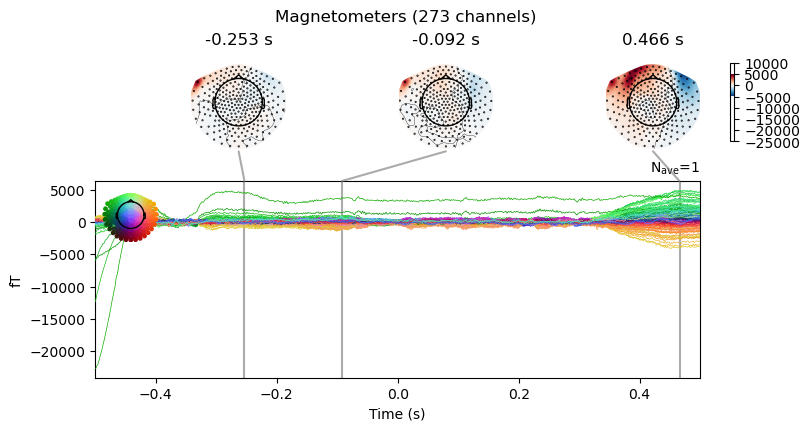

In [6]:
reject_criteria = dict(
    mag=3000e-14,  # 3000 fT
)

flat_criteria = dict(mag=1e-14)
eog_epochs = mne.preprocessing.create_eog_epochs(raw, baseline=(-0.5, -0.2),  reject=reject_criteria, flat=flat_criteria)
eog_epochs.plot_image(combine="mean", picks=['mag'])
eog_evoked = eog_epochs.average()
eog_evoked.plot_joint(picks=['mag'])

In [8]:
ica = ICA(n_components=30, max_iter="auto", random_state=97)
ica.fit(filt_raw, picks=['mag'])
ica

Fitting ICA to data using 273 channels (please be patient, this may take a while)
Removing 5 compensators from info because not all compensation channels were picked.
Selecting by number: 30 components
Fitting ICA took 168.6s.


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,57 iterations on raw data (3335617 samples)
ICA components,30
Available PCA components,273
Channel types,mag
ICA components marked for exclusion,—


Creating RawArray with float64 data, n_channels=33, n_times=3335617
    Range : 0 ... 3335616 =      0.000 ...  2779.680 secs
Ready.
Using matplotlib as 2D backend.


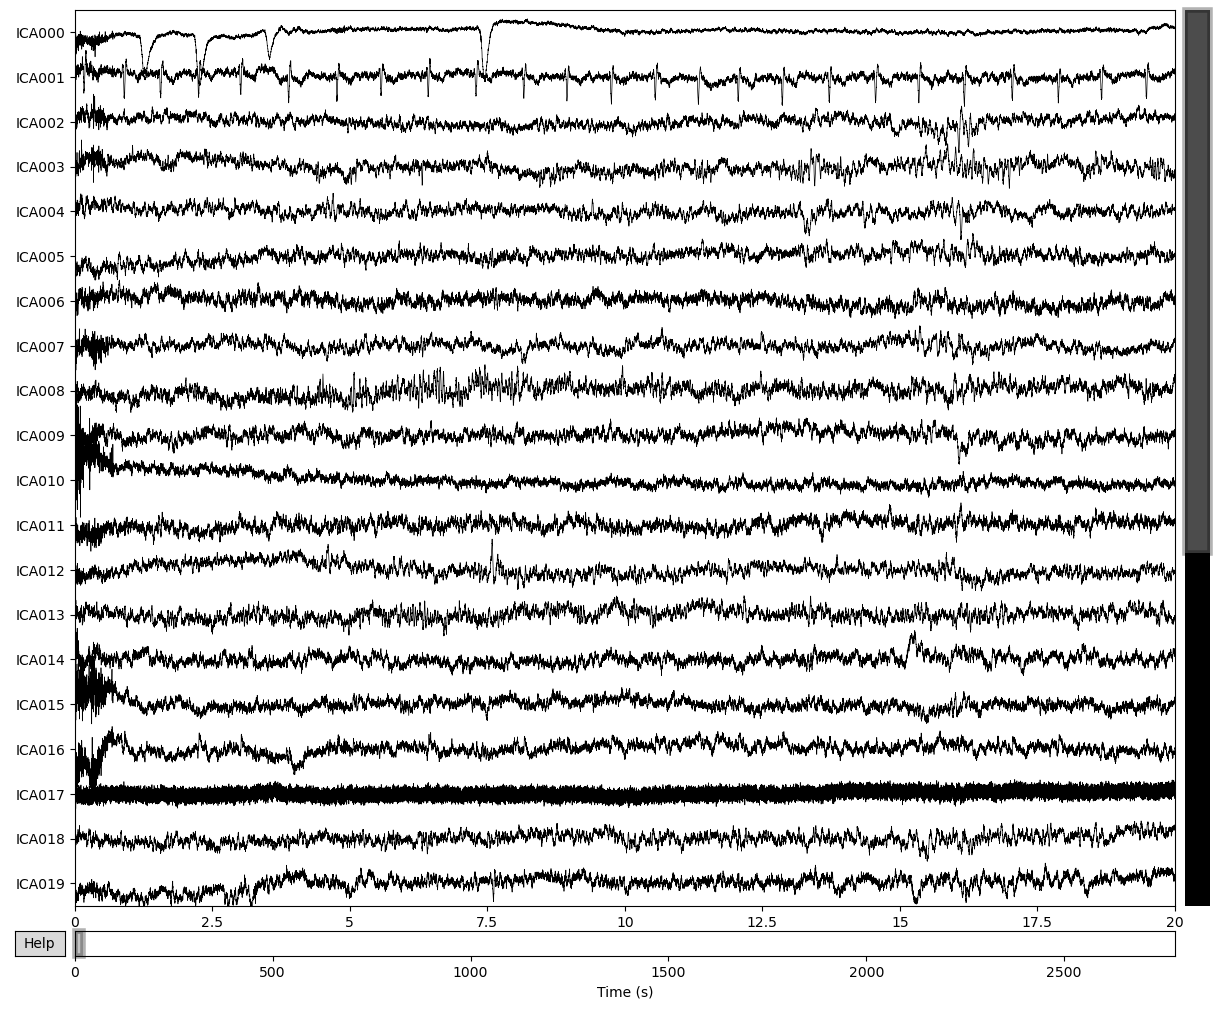

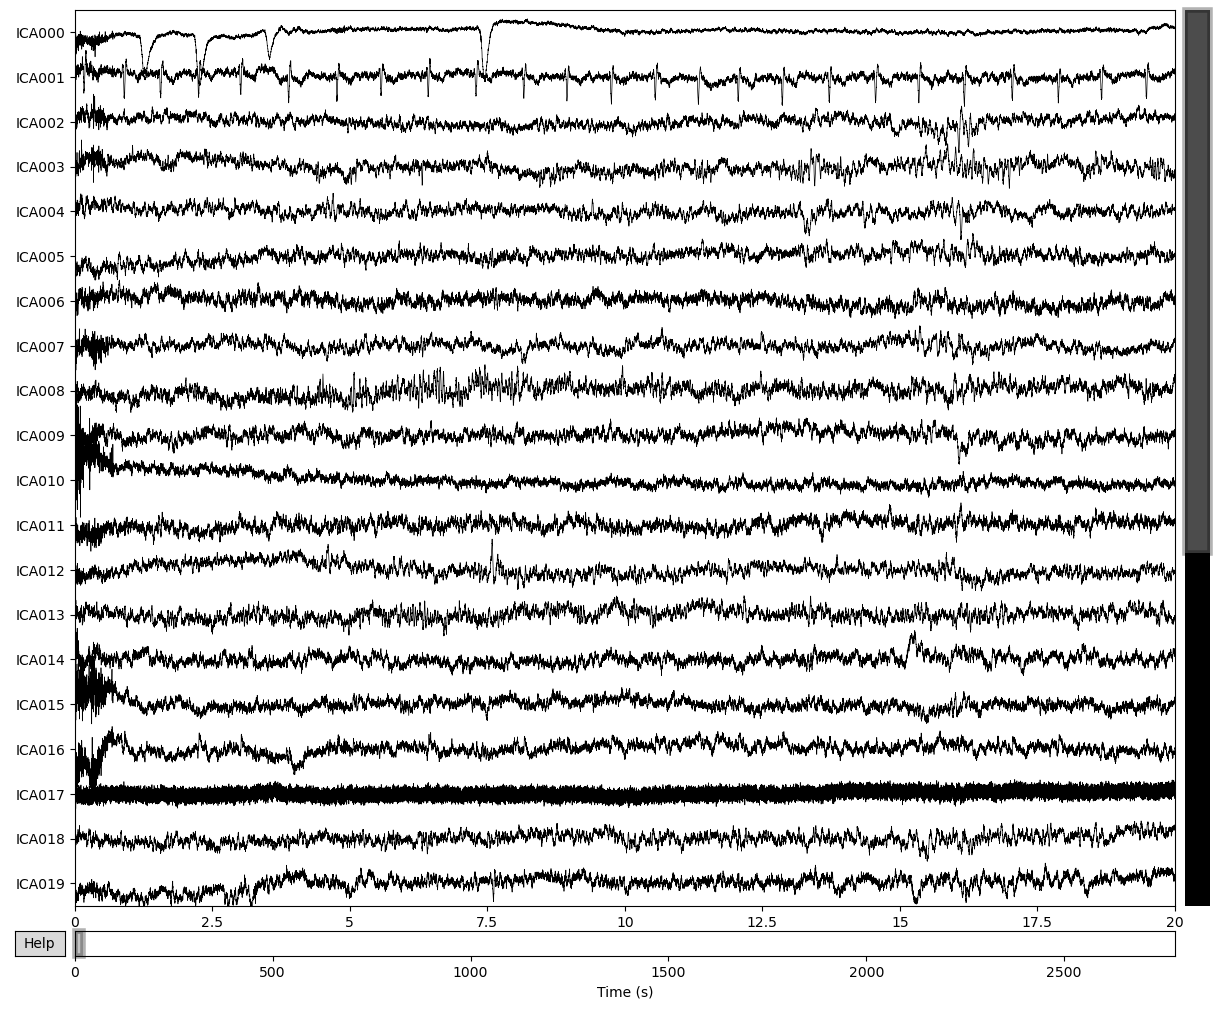

In [9]:
ica.plot_sources(raw, show_scrollbars=True, use_opengl=True)

In [7]:
ica.exclude = []
# find which ICs match the EOG pattern
eog_indices, eog_scores = ica.find_bads_eog(raw)
ica.exclude.extend(eog_indices)

# barplot of ICA component "EOG match" scores
ica.plot_scores(eog_scores)

# plot diagnostics
ica.plot_properties(raw, picks=eog_indices)

# plot ICs applied to raw data, with EOG matches highlighted
ica.plot_sources(raw, show_scrollbars=False)

# plot ICs applied to the averaged EOG epochs, with EOG matches highlighted
ica.plot_sources(eog_evoked)

NameError: name 'ica' is not defined

In [11]:
eog_indices

[0, 22]

Using channel EEG059 to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 12000 samples (10.000 s)

Number of ECG events detected : 3509 (average pulse 75 / min.)
Not setting metadata
3509 matching events found
No baseline correction applied
Using data from preloaded Raw for 3509 events and 1201 original time points ...
    Rejecting  epoch based on MAG : ['MLF14-4304', 'MLT21-4304', 'MLT31-4304', 'MLT41-4304', 'MRF14-4304', 'MRF25-4304', 'MRT11-4304', 'MRT14-4304', 'MRT15-4304', 'MRT21-4304', 'MRT25-4304', 'MRT31-4304', 'MRT41-4304']
    Rejecting  epoch based 

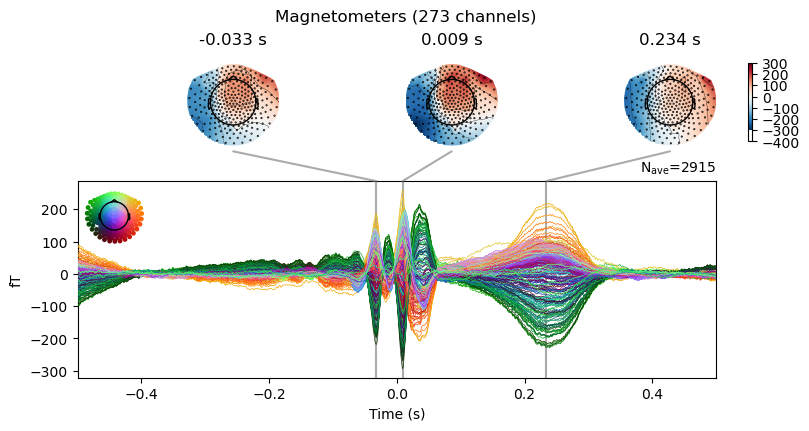

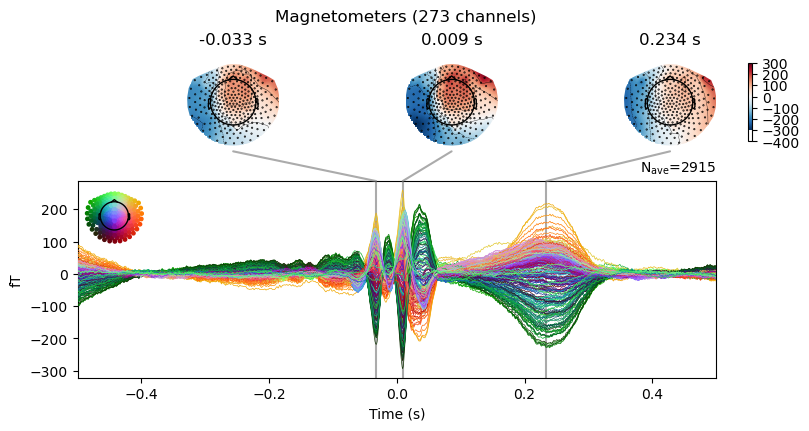

In [12]:
ecg_evoked = create_ecg_epochs(raw, reject=reject_criteria, flat=flat_criteria).average()
ecg_evoked.apply_baseline(baseline=(None, -0.2))
ecg_evoked.plot_joint(picks=['mag'])

... filtering ICA sources
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 12000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.0s


... filtering target
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 12000 samples (10.000 s)



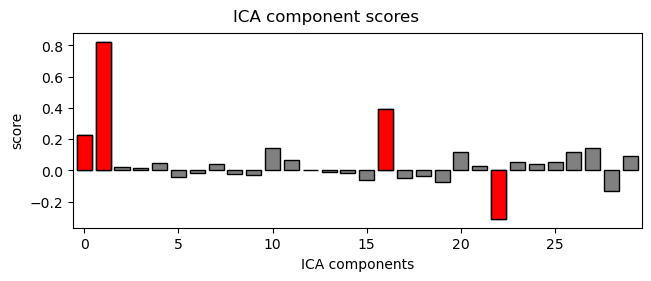

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
625 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
625 matching events found
No baseline correction applied
0 projection items activated


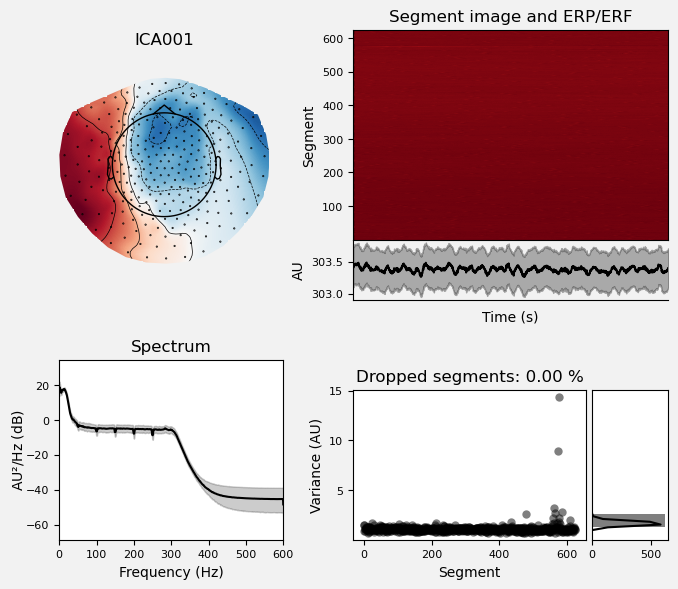

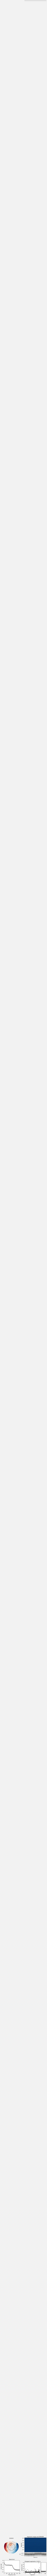

Creating RawArray with float64 data, n_channels=33, n_times=3335617
    Range : 0 ... 3335616 =      0.000 ...  2779.680 secs
Ready.


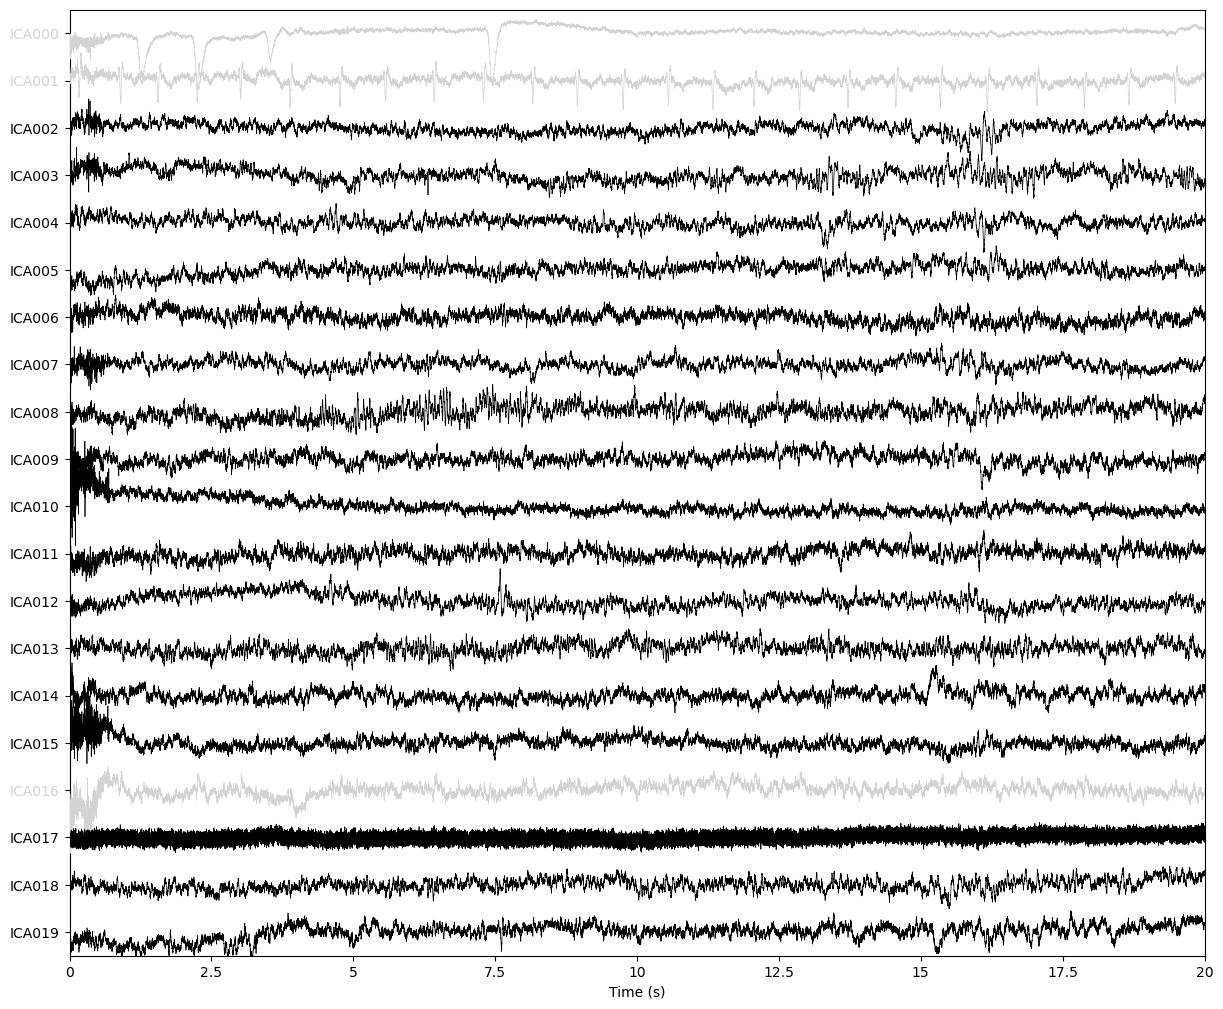

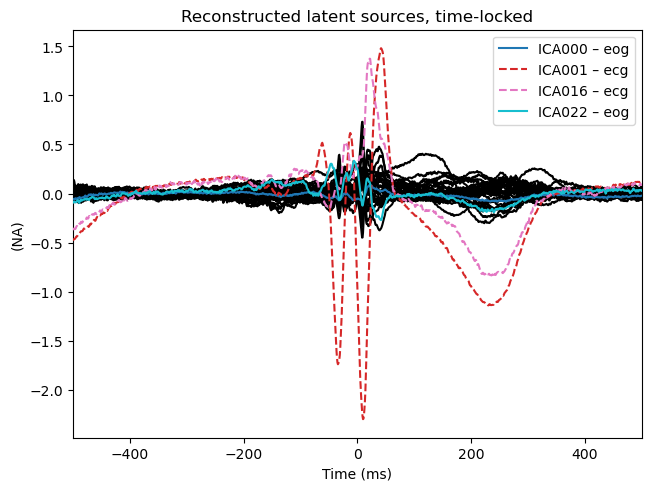

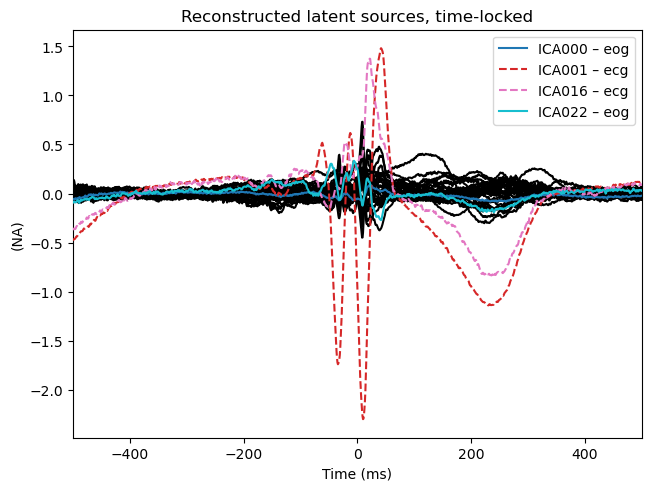

In [13]:
# find which ICs match the ECG pattern
ecg_indices, ecg_scores = ica.find_bads_ecg(raw, method='correlation', measure='zscore', threshold="auto")
ica.exclude.extend(ecg_indices)

# barplot of ICA component "ECG match" scores
ica.plot_scores(ecg_scores)

# plot diagnostics
ica.plot_properties(raw, picks=ecg_indices)

# plot ICs applied to raw data, with ECG matches highlighted
ica.plot_sources(raw, show_scrollbars=False)

# plot ICs applied to the averaged ECG epochs, with ECG matches highlighted
ica.plot_sources(ecg_evoked)

In [14]:
ecg_indices

[1, 16]

In [15]:
len(ica.exclude)

4

In [16]:
reconst_raw = raw.copy()
ica.apply(reconst_raw)
reconst_raw.save(f"{SAVE_DIR}/raw_ecg_eog_repaired_meg.fif", overwrite=True)

Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 4 ICA components
    Projecting back using 273 PCA components
Writing /home/s8/Documents/VU/dataset/workdir/sub-V1006/raw_ecg_eog_repaired_meg.fif


FileNotFoundError: [Errno 2] No such file or directory: '/home/s8/Documents/VU/dataset/workdir/sub-V1006/raw_ecg_eog_repaired_meg.fif'